In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats # Здесь сидят функции проверки гипотез
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns


Пример 1

Дома в Альбукерке (на углу VS не на углу)

Мы занимаемся продажей домов.  Ассоциация риелторов фиксирует каждую сделку о покупке и продаже дома. Для каждого дома мы знаем: 
- Цена (в сотнях долларов)
- Площадь (в футах квадратных)
- Возраст
- Количество дополнительных удобств (посудомоечная машина, холодильник, микроволновая печь, измельчитель, стиральная машина, домофон, окно в крыше, компактор, сушилка, пандус, доступ к кабельному телевидению)
- Расположен в северо-восточном секторе города (престижный район) (Да (1) или Нет (0))
- Изготовлен на заказ
- Расположен на углу 
- Ежегодные налоги за владение домом

В Китае дома на угла пользуются меньшим спросом, считается, что в них скапливается отрицательная энергия. Давайте проверим, есть ли подобное предубеждение в Альбукерке. 

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/IlyaShirmanov/Portfolio_Data_Science_Files/main/Albuquerque_Home_Prices_data.txt', sep='\t')

In [ ]:
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13,7,1,1,0,1639
1,2080,2600,-9999,4,1,1,0,1088
2,2150,2664,6,5,1,1,0,1193
3,2150,2921,3,6,1,1,0,1635
4,1999,2580,4,4,1,1,0,1732


Хотим проверить, что цены домов на углу (```COR = 1```) отличаются от цен домов не на углу (```COR = 0```). Хотим попробовать применить критерий Стьюдента, но для этого нужно:
1. Проверить нормальность данных,
2. Проверить равенство дисперсий.

Очевидно, что значение -9999 здесь употребляется в качестве пустого значения. Нужно заменить его на корректное пустое значение.

In [ ]:
df = df.replace(-9999, np.nan)

In [ ]:
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0


Сохраним в отдельные переменные выборки, которые собираемся сравнивать.

In [ ]:
x = df[df['COR'] == 1]['PRICE']
y = df[df['COR'] == 0]['PRICE']
x.name, y.name = 'corner', 'not corner'

Проверяем нормальность распределений.

In [ ]:
# Создадим простую функцию для визуализации распределения пары выборок.
def two_histograms(x, y):
    # После определения функции полезно бывает добавить её описание в таком стиле.
    # Тройные кавычки -- для обрамления многострочных строковых литералов.
    """
    Функция, которая построит две гистограммы на одной картинке.
    Дополнительно пунктирными линиями указываются средние значения выборок.
    x: вектор pd.Series,
    y: вектор pd.Series
    """
    # alpha - прозрачность, weights - позволяет задать веса, по которым мы строим гистограмму.
    x.hist(alpha=0.5, weights=[1./len(x)]*len(x))  
    y.hist(alpha=0.5, weights=[1./len(y)]*len(y))
    plt.axvline(x.mean(), color='red', alpha=0.8, linestyle='dashed')
    plt.axvline(y.mean(), color='blue', alpha=0.8, linestyle='dashed')
    plt.legend([x.name, y.name])

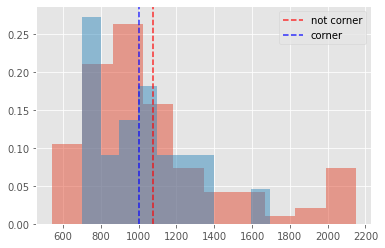

In [ ]:
# вызываем функцию для определённых выше векторов x, y.
two_histograms(y, x)

В распределении есть очевидные выбросы, которые не дают применить критерий Стюдента. Можно было бы попробовать избавиться от них, но первой (синей) гистограмме это не поможет - выброс у неё всего один, и его удаление не сделает данные более нормальными: слишком уж большой крайний левый столбик. Тогда можно поробовать применить непараметрические критерии. Критерий Уилкоксона применим только для парных выборок. У нас же в разных выборках находятся разные объекты (дома). Поэтому нам остаётся критерий Манна-Уитни.

- парные выборки - две выборки набираются таким образом, что с каждым наблюдением одной выборки сопоставлено наблюдение другой выборки;

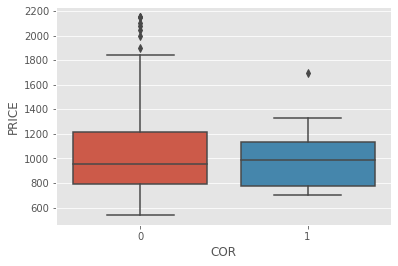

In [ ]:
# За одно посмотрим на "ящики с усами", поскольку в нашей визуализации из нет (для большей читаемости)
sns.boxplot(
    x='COR',
    y='PRICE',
    data=df
);

Судя по графику, медиана будет отличаться статистически незначимо. 
Так же можно сделать вывод, что среди угловых домов редко встречаются очень дорогие.

Нипишем мини-функцию, поясняющую результат теста с возможностью указывать уровень значимости, и дополнительным сообщением, насколько сильным было отклонение от заданного показателя. 

In [ ]:
def stats_manna_whitneyu(x, y, significance_level = 0.05, alternative = "two-sided", axis = 0, method = 'auto', use_continuity = True):
    """
    Функция стат. теста Манна-Уитни
    Принимает переменные x, y
    Имеет следующие параметры, которые можно изменять:
    significance_level (доверительный интервал) по умолчанию = 0.05, 
    а так же параметры функции scipy.stats.mannwhitneyu (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)
    """
    res = stats.mannwhitneyu(x, y, alternative = alternative, axis = axis, method = method, use_continuity = use_continuity)
    print(f'p-value = {res[1]}')
    print(f'От заданного показателя уровня значимости в {significance_level} отклонение составляет {res[1] - significance_level}')
    if res[1] - significance_level > 0:
      print('Нет оснований отвергнуть гипотезу H0')
    else:
      print('Принимается гипотеза Н1')

Проведем стат тест Манна-Уитни

Н0 цены домов на углу (COR = 1) не отличаются от цен домов не на углу (COR = 0).

Н1 цены домов на углу (COR = 1) отличаются от цен домов не на углу (COR = 0).
Уровень значимости 0.05

In [ ]:
stats_manna_whitneyu(x, y)

p-value = 0.8044081572425339
От заданного показателя уровня значимости в 0.05 отклонение составляет 0.7544081572425338
Нет оснований отвергнуть гипотезу H0


Задача 2:
    
Проанализировать цены на дома на северо-восток и остальные, сделать гипотезы по графикам, проверить их соответствующими тестами

In [ ]:
x = df[(df['PRICE'] == df['PRICE']) & (df['NE'] == 1)]['PRICE']
y = df[(df['PRICE'] == df['PRICE']) & (df['NE'] == 0)]['PRICE']
x.name, y.name = 'NE', 'not NE'

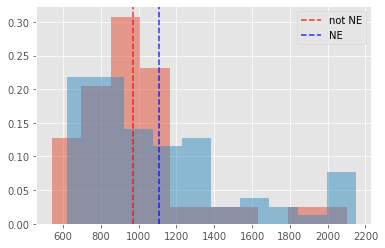

In [ ]:
two_histograms(y, x)

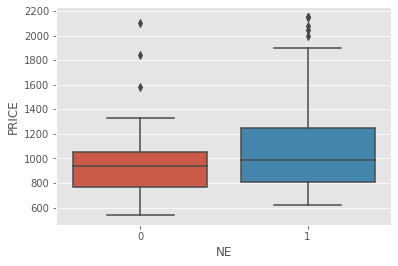

In [ ]:
sns.boxplot(
    x='NE',
    y='PRICE',
    data=df
);

In [ ]:
# Исходя из графиков мы видим что медианы распоположены близко друг и другу.
# Посмотрим точные числовые значения медиан.
# Проведем стат. тест о равенстве медиан (критерий Муда)
# Гипотеза Н0 медианная стоимость жилья статистически значимо не отличается.
# Гипотеза Н1 медианная стоимость жилья разная.
# Уровень доверия 95% (p-value = 0.05)


print (x.median(), y.median())
res = stats.median_test(x, y)
print(f'p-value = {res[1]}')

985.0 940.0
p-value = 0.4720677479376454


In [ ]:
# Вывод нет оснований отвергнуть гипотезу H0 (Медианная стоимость жилья статистически значимо не отличается).

<div class="alert alert-info">
<b>* Задача 3 *: </b>
    
Сделать выводы о цене относительно количества удобств. (поправка Бонферрони, сделайте выводы без неё и проверьте, останутся ли они верны после)
    
    
Собрать и обосновать наиболее удачную конфигурацию дома (представьте, что будете рекламировать клиенту дом, указывая, чем он так хорош), учитываю как цену, так и ежегодные налоги. 
</div>

In [ ]:
groups = df.groupby('FEATS')
alpha = 0.05
baseline = groups.get_group(0)['PRICE']
for Feat in range(1, len(groups)):
    a = groups.get_group( Feat )['PRICE']
    p_val = stats.ttest_ind(a, baseline, equal_var = False).pvalue 
    if p_val != p_val:
      print(f'Для дома с {Feat} удобством(и) недостаточное количество данных для анализа. P-value = {p_val}.')
    elif p_val < alpha: 
      print(f'Стоимость дома с {Feat} удобством(и) значимо отличается от дома без удобств. P-value = {p_val}. При уровне значимости в {alpha}')
    else:
      print(f'Стоимость дома с {Feat} удобством(и) не значимо отличается от дома без удобств. P-value = {p_val}. При уровне значимости в {alpha}')

Стоимость дома с 1 удобством(и) не значимо отличается от дома без удобств. P-value = 0.13748857389373545. При уровне значимости в 0.05
Стоимость дома с 2 удобством(и) значимо отличается от дома без удобств. P-value = 0.03626550423153086. При уровне значимости в 0.05
Стоимость дома с 3 удобством(и) значимо отличается от дома без удобств. P-value = 0.008437450198450712. При уровне значимости в 0.05
Стоимость дома с 4 удобством(и) значимо отличается от дома без удобств. P-value = 0.0072731474758518985. При уровне значимости в 0.05
Стоимость дома с 5 удобством(и) значимо отличается от дома без удобств. P-value = 0.0007890839826641991. При уровне значимости в 0.05
Стоимость дома с 6 удобством(и) значимо отличается от дома без удобств. P-value = 0.014801084163972546. При уровне значимости в 0.05
Для дома с 7 удобством(и) недостаточное количество данных для анализа. P-value = nan.
Для дома с 8 удобством(и) недостаточное количество данных для анализа. P-value = nan.


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
groups = df.groupby('FEATS')
alpha = 0.05/(len(groups))
baseline = groups.get_group(0)['PRICE']
for Feat in range(1, len(groups)):
    a = groups.get_group( Feat )['PRICE']
    p_val = stats.ttest_ind(a, baseline, equal_var = False).pvalue 
    if p_val != p_val:
      print(f'Для дома с {Feat} удобством(и) недостаточное количество данных для анализа. P-value = {p_val}.')
    elif p_val < alpha: 
      print(f'Стоимость дома с {Feat} удобством(и) значимо отличается от дома без удобств. P-value = {p_val}. При уровне значимости в {alpha}')
    else:
      print(f'Стоимость дома с {Feat} удобством(и) не значимо отличается от дома без удобств. P-value = {p_val}. При уровне значимости в {alpha}')

Стоимость дома с 1 удобством(и) не значимо отличается от дома без удобств. P-value = 0.13748857389373545. При уровне значимости в 0.005555555555555556
Стоимость дома с 2 удобством(и) не значимо отличается от дома без удобств. P-value = 0.03626550423153086. При уровне значимости в 0.005555555555555556
Стоимость дома с 3 удобством(и) не значимо отличается от дома без удобств. P-value = 0.008437450198450712. При уровне значимости в 0.005555555555555556
Стоимость дома с 4 удобством(и) не значимо отличается от дома без удобств. P-value = 0.0072731474758518985. При уровне значимости в 0.005555555555555556
Стоимость дома с 5 удобством(и) значимо отличается от дома без удобств. P-value = 0.0007890839826641991. При уровне значимости в 0.005555555555555556
Стоимость дома с 6 удобством(и) не значимо отличается от дома без удобств. P-value = 0.014801084163972546. При уровне значимости в 0.005555555555555556
Для дома с 7 удобством(и) недостаточное количество данных для анализа. P-value = nan.
Для д

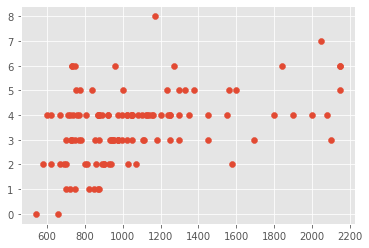

In [ ]:
plt.scatter(df['PRICE'], df['FEATS']);

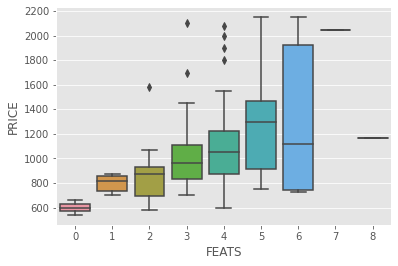

In [ ]:
sns.boxplot(
    x='FEATS',
    y='PRICE',
    data=df
);

In [ ]:
x = df[(df['TAX'] == df['TAX']) & (df['NE'] == 1)]['TAX']
y = df[(df['TAX'] == df['TAX']) & (df['NE'] == 0)]['TAX']
x.name, y.name = 'NE', 'not NE'

In [ ]:
#Проведем анализ налогов в зависимости от района города.

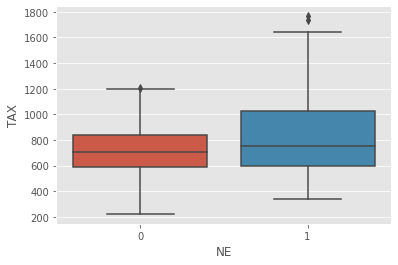

In [ ]:
sns.boxplot(
    x='NE',
    y='TAX',
    data=df
);

In [ ]:
# Исходя из графика мы видим, что медианы расположены близко друг и другу.
# Посмотрим точные числовые значения медиан.
# Проведем стат. тест о равенстве медиан (критерий Муда)
# Гипотеза Н0 медианная налоговая нагрузка на жилье в зависимости от района статистически значимо не отличается.
# Гипотеза Н1 медианная налоговая нагрузка на жилье в зависимости от района разная.
# Уровень доверия 95% (p-value = 0.05)
print (x.median(), y.median())
res = stats.median_test(x, y)
print(f'p-value = {res[1]}')

750.0 704.0
p-value = 0.3399737558061884


In [ ]:
# Вывод нет оснований отвергнуть гипотезу H0 (медианная налоговая нагрузка на жилье в зависимости от района статистически значимо не отличается)

In [ ]:
# Исходя из анализа можно порекомендовать дом в престижной районе, с 6 удобствами (хотя предложений мало), не угловой т.к. судя по исследованиям на цену это не влияет.
# Что касаемо площади она прямо коррелирует с ценой, поэтому тут все зависит от финансовых возможностей заказчика.

Пример 2.

Возраст, в котором умирают европейские аристократы.

Интересный датасет середины 19 века. Данные о возрасте, в котором умирали европейцы, в зависимости от их класса (sovereignty, aristocracy, and gentry).

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/IlyaShirmanov/Portfolio_Data_Science_Files/main/agedeath.dat.txt', sep='\s+', header=None,
                 names=['group', 'age', 'index'])  # сословие, возраст, номер
# sep='\s+' - в качестве разделителя мы выбираем любое число пробелов

In [ ]:
df.head()

,group,age,index
0,aris,21,1
1,aris,21,2
2,aris,21,3
3,aris,21,4
4,aris,21,5


In [ ]:
x = df[df['group'] == 'sovr']['age']
y = df[df['group'] == 'aris']['age']
x.name, y.name = 'sovr', 'aris'

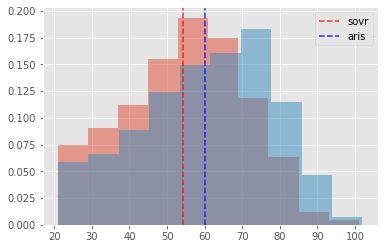

In [ ]:
two_histograms(x, y)

Данные условно нормальны. Проверим c помощью критерия Флигнера-Килина, равны ли дисперсии, поскольку t-test хочет еще и с равными дисперсиями данные. 

In [ ]:
res = stats.fligner(x, y)
print('p-value: {0}'.format(res[1]))

p-value: 0.00010116077103844913


Значение p-value низкое, поэтому гипотезу о равенстве дисперсий отвергаем. В двух выборках находятся разные наблюдаемые объекты, то есть выборки ```несвязные```. 

Итого, гипотезу о равенстве средних значений будем проверять с помощью ```ttest_ind``` с опцией ```equal_var=False```.

In [ ]:
res = stats.ttest_ind(x, y, equal_var=False)
print('p-value: {0}'.format(res[1]))

p-value: 1.5181184197728794e-26


<div class="alert alert-info">
<b>Задача 1: </b>
    
Интерпретация результатов
</div>

После проверки гипотезы необходимо произвести интерпритацию результатов, поскольку задача предполагает решение некой проблемы или ответ на определённый вопрос.  
Какой же вывод мы можем сделать, основываясь на полученных результатах? 

In [ ]:
# Данный тест проверкяет нулевую гипотезы о том, что 2 независимые выборки имеют одинаковые средние значения.
# => Н0 - средняя продолжительность жизни sovereignty, aristocracy одинаковая
# Н1 - средняя продолжительность жизни sovereignty, aristocracy разная
# p-value очень низкое НО отвергаем
# => Средняя продолжительность жизни sovereignty, aristocracy разная



Задача 2:
    
Сделать выводы о всех трёх группах.

In [ ]:
#Построим визуализации для предварительного анализа

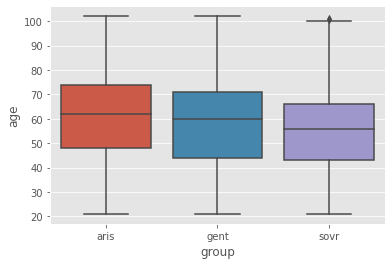

In [ ]:
sns.boxplot(
    x='group',
    y='age',
    data=df
);

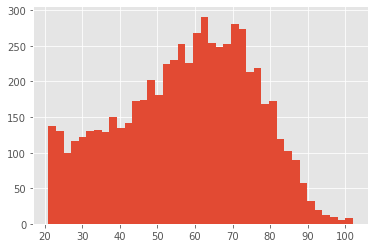

In [ ]:
plt.hist((df[u'age']), bins=40);

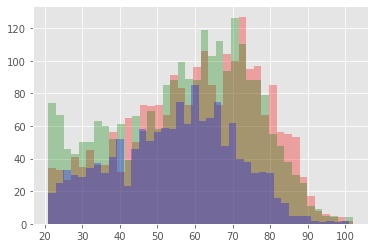

In [ ]:
groups = df.groupby('group')
plt.hist((groups.get_group('aris')['age']), bins=40, color = 'r', alpha = 0.3);
plt.hist((groups.get_group('gent')['age']), bins=40, color = 'g', alpha = 0.3);
plt.hist((groups.get_group('sovr')['age']), bins=40, color = 'b', alpha = 0.3);

In [ ]:
#Посмотрим численные значения средней жизни
print(f"Среднее значение жизни aristocracy {np.average(groups.get_group('aris')['age'])}")
print(f"Среднее значение жизни gentry {np.average(groups.get_group('gent')['age'])}")
print(f"Среднее значение жизни sovereignty {np.average(groups.get_group('sovr')['age'])}")

Среднее значение жизни aristocracy 60.233522479266696
Среднее значение жизни gentry 57.307942973523424
Среднее значение жизни sovereignty 54.232638888888886


In [ ]:
# Проведем исследование равенства средней жизни аристократов
# Выдвенем гипотезы
# Н0 - средняя продолжительность жизни sovereignty, aristocracy, and gentry одинаковая
# Н1 - средняя продолжительность жизни sovereignty, aristocracy, and gentry разная



In [ ]:
groups = df.groupby('group')
alpha = 0.05/(len(groups))
baseline = groups.get_group('aris')['age']
for Feat in groups:
    a = Feat[1]['age']
    p_val = stats.ttest_ind(a, baseline, equal_var = False).pvalue 
    if p_val != p_val:
      print(f' Сословие {Feat[0]} P-value = {p_val}.')
    elif p_val < alpha: 
      print(f' Сословие {Feat[0]} P-value = {p_val}.')
    else:
      print(f' Сословие {Feat[0]} P-value = {p_val}.')

 Сословие aris P-value = 1.0.
 Сословие gent P-value = 1.3630223411037013e-08.
 Сословие sovr P-value = 1.5181184197728794e-26.


In [ ]:
# Сравниваем 3 сословия aris = 1 сравнивается сам с собой
# Остальные сословия p-value очень низкое НО отвергаем
# Средняя продолжительность жизни sovereignty, aristocracy, and gentry разная

Пример 3. 

Правда ли эксперт по Data Science таковым является

<div class="alert alert-info">
<b>Задание 1: </b>
    
Пусть, вы хотите проверить правда ли эксперт по Data Science таковым является. Вы составили список вопросов, спросили эксперта и случайных прохожих. Количество правильный вопросов по каждому разделу вы записали в таблицу (таблица смежности)

Выясните, исходя из полученных данных, действительно ли перед вами эксперт или он знает не больше, чем случайный прохожий? Сделайте вывод на основании результата. 
    
</div>

In [ ]:
contingency_table =\
    pd.DataFrame([[22, 99, 59], [10, 12, 31]],
                 columns=['SQL', 'Machine Learning', 'Analytics'],
                 index=['Эксперт', 'Случайный прохожий'])

print('Таблица сопряжённости')
contingency_table

Таблица сопряжённости


,SQL,Machine Learning,Analytics
Эксперт,22,99,59
Случайный прохожий,10,12,31


In [ ]:
# Проверяем гипотезу о равенстве доли признака (Знает ли эксперт больше чем прохожий)
#Гипотеза Н0 - эксперт по Data Science знает столько же чем случайный прохожий.
#Гипотеза Н1 - эксперт по Data Science знает больше чем случайный прохожий.
#
res = stats.chi2_contingency(contingency_table)
print('p-value: {0}'.format(res[1]))

p-value: 0.00017303774198262266


In [ ]:
# Вывод p-value низкий гипотезу Н0 отвергаем.
# Эксперт по Data Science знает больше чем случайный прохожий.